# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine.
Scaffolded by Professor Paul Robustelli and completed by Jacob Wesley Dell for 18 January 2022 (revised for the end of the term).

---
### setting up the environment for MD calculations

installed: all necessary libraries and packages for our simulation.

main packages:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
3.    py3Dmol (https://pypi.org/project/py3Dmol/)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

In [1]:
# load dependencies
import os
import sys

from simtk import openmm as mm
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

import matplotlib.pyplot as plt
import scipy.stats as stats
import MDAnalysis as mda
import seaborn as sb
import mdtraj as md
import pandas as pd
import numpy as np
import py3Dmol
import platform
import scipy.cluster.hierarchy

from scipy.spatial.distance import squareform
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

from IPython.display import set_matplotlib_formats
from statistics import mean, stdev
from matplotlib import colors

from simtk import unit
from openmm import app

# not using pytraj
#import pytraj as pt
#from pytraj import matrix

In [2]:
# set up directories
workDir = 'project1_data/outdir/'
initial_pdb = 'project1_data/butane.pdb'
force_field = 'project1_data/butane.gaff2.xml'

if not os.path.exists(workDir):
    os.makedirs(workDir)

# from __future__ import print_function
# print(initial_pdb)
# print(force_field)

# set up simulation
pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)
system = forcefield.createSystem(pdb.topology,nonbondedMethod=mm.app.NoCutoff,constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin,5.0/unit.picoseconds,2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology,system,integrator,platform)
simulation.context.setPositions(pdb.positions)

In [3]:
print('minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)
st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"potential energy after minimization is {st.getPotentialEnergy()}")

minimizing...
potential energy before minimization is 5.797528692127868 kJ/mol
potential energy after minimization is 5.295784483017471 kJ/mol


In [4]:
from sys import stdout
print('equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout,100,step=True, 
    potentialEnergy=True,temperature=True,separator=', '))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

equilibrating...
#"Step", "Potential Energy (kJ/mole)", "Temperature (K)"
100, 30.144230605971035, 180.9631480139806
200, 26.152513488009287, 219.05236907737682
300, 46.76484420839013, 471.38046828597237
400, 37.492365779801865, 322.16836255679874
500, 32.97474337867254, 449.8702549357683
600, 47.01776945652898, 282.0159663112594
700, 63.187288724749976, 261.69102864016213
800, 43.0414018272157, 389.6474937032701
900, 43.44829000134274, 286.73377677381274
1000, 36.7728258012045, 194.20695381968775
1100, 28.521344502937517, 371.412131194291
1200, 42.264685704625364, 280.1194947570994
1300, 30.453611634177165, 337.93051483471396
1400, 32.96993713189172, 383.51388292140433
1500, 33.64127811025437, 438.195854121451
1600, 38.621536365812716, 306.2986608575566
1700, 59.42461803672472, 173.43415599772592
1800, 44.966212672024724, 205.6045834290636
1900, 38.79353838066825, 343.4337568554065
2000, 44.58822307377487, 342.15970771542095
2100, 58.77808013826184, 368.92015982684325
2200, 47.8311424

In [5]:
import time as time
print('running production...')

# begin timer
tinit = time.time()

# clear simulation reporters
simulation.reporters.clear()

# reinitialize simulation reporters
# we do this because we want different information printed
#  for the production run from the equilibration run.
# output basic simulation information below every 250000 steps
#  (2 fs per step, so 500000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout,250000, 
    step=True,time=True,potentialEnergy=True,temperature=True, 
    speed=True,separator=', '))

# write out a trajectory (i.e., coordinates vs. time)
#  to a DCD file every 100 steps or 0.2 ps
simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd',100))

# run the simulation for 1.0x10^7 steps or 20 ns
simulation.step(1000000)

# end timer
tfinal = time.time()
print('done!')
print('time required for simulation:',tfinal-tinit,'seconds')

running production...
#"Step", "Time (ps)", "Potential Energy (kJ/mole)", "Temperature (K)", "Speed (ns/day)"
250000, 500.0000000016593, 38.07390101393251, 182.70182014888718, 0
500000, 999.9999999901769, 33.68131939896128, 405.029108839341, 2.84e+03
750000, 1499.9999999783536, 52.532122103928856, 301.11303794912845, 2.88e+03
1000000, 1999.9999999665301, 39.6147861374941, 312.83779955641444, 2.87e+03
done!
time required for simulation: 60.87540411949158 seconds


In [6]:
# load trajectory
#print(workDir+'butane_sim.dcd')
#simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))
traj = md.load(workDir+'/butane_sim.dcd',top=initial_pdb)
traj
#traj.superpose(ref)

#jupyter-nbextension enable --py --user nglview
#jupyter-nbextension enable --py --user widgetsnbextension 

# show simulation
import ipywidgets
from ipywidgets import interact, fixed
import warnings
import nglview as ngl
from nglview.player import TrajectoryPlayer
traj = md.load(workDir+'/butane_sim.dcd',top=initial_pdb)
t = ngl.MDTrajTrajectory(traj)
w = ngl.NGLWidget(t)
w

NGLWidget(max_frame=9999)

In [7]:
# list atoms and bonds
atoms,bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [8]:
# select the topology
top = traj.topology

# select all carbon atoms
C_sel = top.select("type C")
print(C_sel)

# confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


### class activity: plot the harmonic bond force field term for a C-C bond

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html

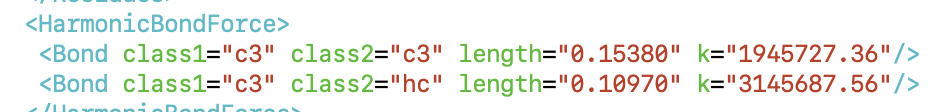

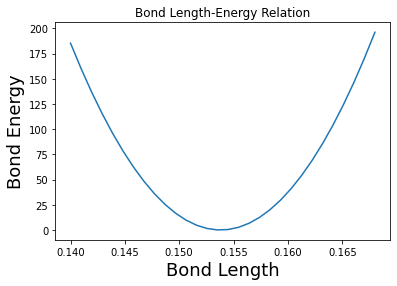

In [9]:
bondlengths = np.linspace(0.140,0.168,30)

# array bond lengths
def harmonic_bond_E(k,b,b0):
    return k/2*(b-b0)**2

Bond_E = harmonic_bond_E(1945727.27,bondlengths,0.15380)
plt.title('Bond Length-Energy Relation')
plt.xlabel('Bond Length',size=18)
plt.ylabel('Bond Energy',size=18)
plt.plot(bondlengths,Bond_E)
plt.show()

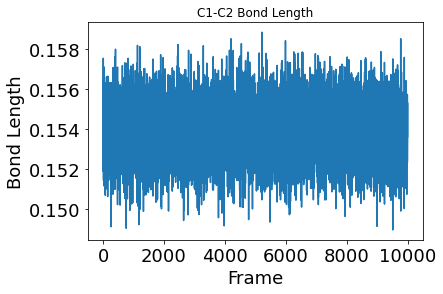

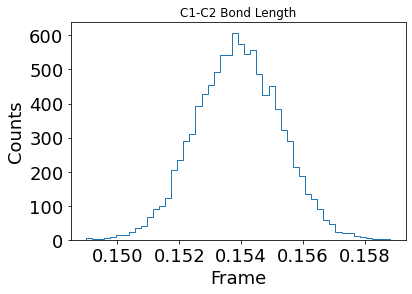

In [10]:
# compute some distances and plot the time course (bond 0-4)
bond_indices = [0,4] 
C1C2bondlength = md.compute_distances(traj,[bond_indices])

plt.plot(C1C2bondlength)
plt.xlabel('Frame',size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length',size=18)
plt.title('C1-C2 Bond Length')
plt.show()
plt.clf()

plt.hist(C1C2bondlength,bins=50,histtype='step')
plt.xlabel('Frame',size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Counts',size=18)
plt.title('C1-C2 Bond Length')
plt.show()

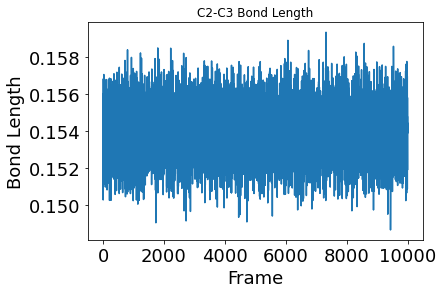

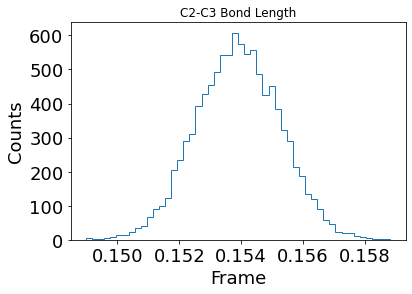

In [11]:
# compute some distances and plot the time course (bond 4-7)

bond_indices = [4,7]
C2C3bondlength = md.compute_distances(traj,[bond_indices])

plt.plot(C2C3bondlength)
plt.xlabel('Frame',size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length',size=18)
plt.title('C2-C3 Bond Length')
plt.show()
plt.clf()

plt.hist(C1C2bondlength,bins=50,histtype='step')
plt.xlabel('Frame',size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Counts',size=18)
plt.title('C2-C3 Bond Length')
plt.show()

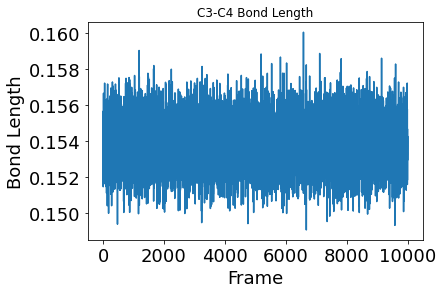

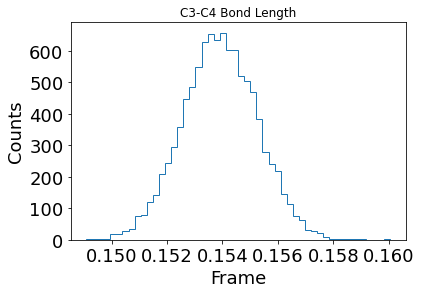

In [12]:
# compute some distances and plot the time course (bond 7-10)
bond_indices = [7,10]
C3C4bondlength = md.compute_distances(traj,[bond_indices])

plt.plot(C3C4bondlength)
plt.xlabel('Frame',size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length',size=18)
plt.title('C3-C4 Bond Length')
plt.show()
plt.clf()

plt.hist(C3C4bondlength,bins=50,histtype='step')
plt.xlabel('Frame',size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Counts',size=18)
plt.title('C3-C4 Bond Length')
plt.show()

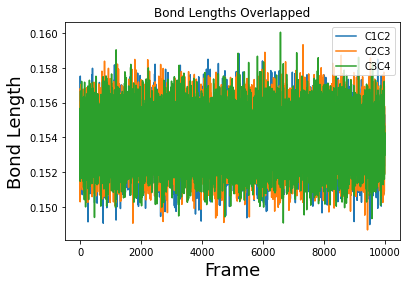

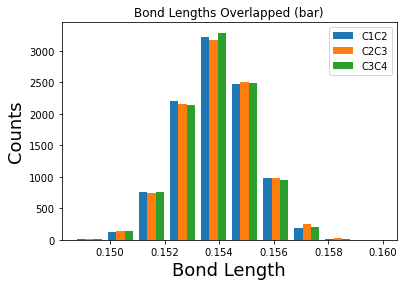

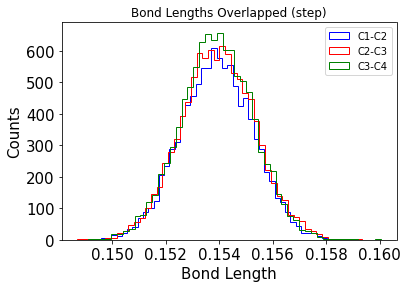

In [13]:
# plot histograms of each bond length
bond_indices = [[0,4],[4,7],[7,10]]
CC_bondlengths = md.compute_distances(traj,bond_indices)

C1C2_bond = np.shape(CC_bondlengths[:,0])
C2C3_bond = np.shape(CC_bondlengths[:,1])
C3C4_bond = np.shape(CC_bondlengths[:,2])

plt.plot(CC_bondlengths,label=['C1C2','C2C3','C3C4'])
plt.title('Bond Lengths Overlapped')
plt.xlabel('Frame',size=18)
plt.ylabel('Bond Length',size=18)
plt.legend()
plt.show()
plt.clf()

plt.hist(CC_bondlengths,label=['C1C2','C2C3','C3C4'])
plt.title('Bond Lengths Overlapped (bar)')
plt.xlabel('Bond Length',size=18)
plt.ylabel('Counts',size=18)
plt.legend()
plt.show()

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.title('Bond Lengths Overlapped (step)')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

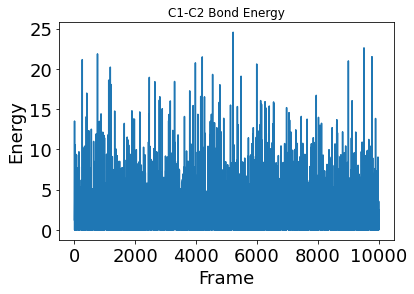

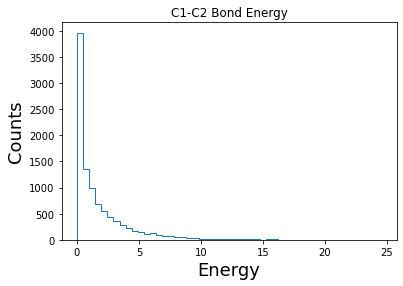

In [14]:
# bond energy
C1C2bond=C1C2bondlength[:,0]
C1C2_BondE=harmonic_bond_E(1945727.27,C1C2bond,0.15380)

plt.plot(C1C2_BondE)
plt.xlabel('Frame',size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Energy',size=18)
plt.title('C1-C2 Bond Energy')
plt.show()
plt.clf()

plt.hist(C1C2_BondE,histtype='step',bins=50)
plt.title('C1-C2 Bond Energy')
plt.xlabel('Energy',size=18)
plt.ylabel('Counts',size=18)
plt.show()

### class activity: calculate the variance ($\sigma^2$) and standard deviation ($\sigma$) of each bond length

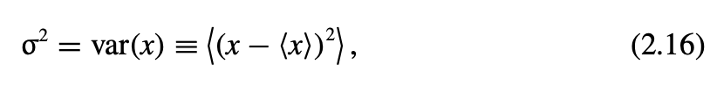

In [15]:
# write a function to calculate variance
def variance(data):
    ave = np.average(data)
    var = np.average((data-ave)**2)
    std = var**0.5
    return var,std

C1C2var,C1C2std = variance(C1C2bondlength)
C2C3var,C2C3std = variance(C2C3bondlength)
C3C4var,C3C4std = variance(C3C4bondlength)
print("from the function:")
print("C1-C2 var:",C1C2var,"\t\tC2-C3 var:",C2C3var,"\t\tC3-C4 var:",C3C4var)
print("C1-C2 stddev:",C1C2std,"\tC2-C3 stddev:",C2C3std,"\tC3-C4 stddev:",C3C4std)

# check with built-in numpy libraries
print("\nnumpy corroboration:")
print("C1-C2 avg:",np.average(C1C2bondlength),
      "\t\t\tC2-C3 avg:",np.average(C2C3bondlength),
      "\t\t\tC3-C4 avg:",np.average(C3C4bondlength))
print("C1-C2 var:",np.var(C1C2bondlength),
      "\t\tC2-C3 var:",np.var(C2C3bondlength),
      "\t\tC3-C4 var:",np.var(C3C4bondlength))
print("C1-C2 stddev:",np.std(C1C2bondlength),
      "\t\tC2-C3 stddev:",np.std(C2C3bondlength),
      "\t\tC3-C4 stddev:",np.std(C3C4bondlength))
print("\n\033[92mperfect!")

from the function:
C1-C2 var: 1.8384745e-06 		C2-C3 var: 1.9173426e-06 		C3-C4 var: 1.8190544e-06
C1-C2 stddev: 0.001355903584965936 	C2-C3 stddev: 0.0013846814129405117 	C3-C4 stddev: 0.001348723260130496

numpy corroboration:
C1-C2 avg: 0.15389535 			C2-C3 avg: 0.15394142 			C3-C4 avg: 0.15390335
C1-C2 var: 1.8384745e-06 		C2-C3 var: 1.9173426e-06 		C3-C4 var: 1.8190544e-06
C1-C2 stddev: 0.0013559036 		C2-C3 stddev: 0.0013846814 		C3-C4 stddev: 0.0013487233

perfect!


### class activity: check if these bond lengths are correlated and calculate the correlation coefficents

***first, calculate a line of best fit***

using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***now, calculate the Pearson correlation coefficient***

also using numpy: 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

this function works for n-arrays, so it will report a correlation coefficient matrix; we need to select our coefficient of interest (in our case, the off-diagonal)

r: -0.10736481197071171
line parameters: [-0.10964354  0.17081505]


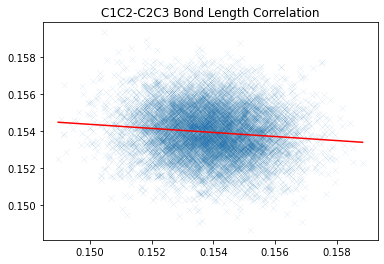

r: 0.0027365691223208395
line parameters: [0.00272208 0.15348444]


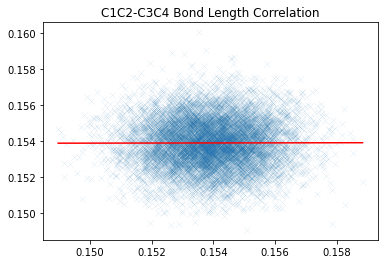

In [16]:
# plot all C1-C2 and C2-C3 bond lengths together
plt.scatter(C1C2bondlength[:,0],C2C3bondlength[:,0],marker='x',linewidth=.05)

# find correlation coefficient
r = np.corrcoef(C1C2bondlength[:,0],C2C3bondlength[:,0])[0,1]
print("r:",r)

# find line of best fit
line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]),max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("line parameters:",line_fit)

plt.title('C1C2-C2C3 Bond Length Correlation')
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

# repeat with C3-C4
plt.scatter(C1C2bondlength[:,0],C3C4bondlength[:,0],marker='x',linewidth=.05)
r = np.corrcoef(C1C2bondlength[:,0],C3C4bondlength[:,0])[0,1]
print("r:",r)
line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]),max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("line parameters:",line_fit)
plt.title('C1C2-C3C4 Bond Length Correlation')
plt.plot(x,y,c='r',label='best fit line')
plt.show()

### homework question: why does one pair of these bonds appear more correlated than the other?

the correlation between the C<sub>1</sub>-C<sub>2</sub> and C<sub>3</sub>-C<sub>4</sub> bonds appears to be greater because they are the "outside" bonds of butane (connecting primary carbons instead of secondary)

### class activity: turn these histograms into probability densities; fit them to a normal (Gaussian) distribution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

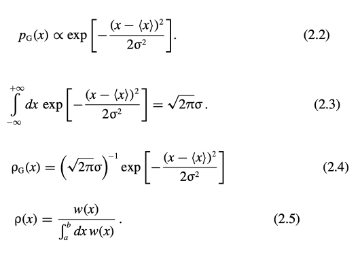
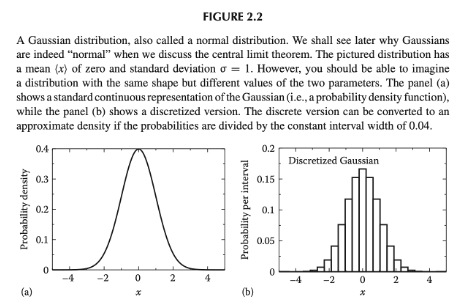

a: 0.18773970841018028 	x0: 0.15389817493678798 	fit_sigma: -0.0013859064249530882
a: 0.18560084095811422 	x0: 0.1539268932854787 	fit_sigma: -0.0013970829438821686
a: 0.19084375397694023 	x0: 0.15390240357694482 	fit_sigma: 0.0013587601286486296


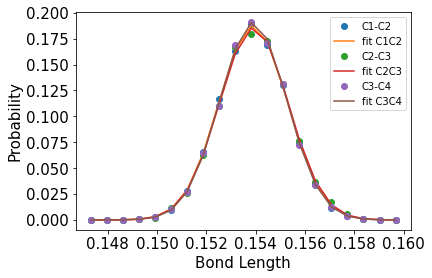

In [17]:
# pull out the data in a formate we can fit
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from scipy.optimize import curve_fit

# convert histogram into bin centers and probabilities
#  (instead of bin edges and counts)
counts,edges = np.histogram(C1C2bond,bins=20,range=[0.147,0.160])
centers = edges[:-1] + np.diff(edges)/2
density = counts / np.sum(counts)

# define a gaussian function to fit to our probability densities
def histogram_bincenters(a,x0,xmax,bins):
    counts, edges = np.histogram(a,bins=bins,range=[x0, xmax])
    centers = edges[:-1] + np.diff(edges) / 2
    density = counts / np.sum(counts)
    return density,centers

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

# define a function to fit the gaussian with a curve
def fit_gauss(x,y):
    parameters,covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"\tx0:",fit_x0,"\tfit_sigma:",fit_sigma)
    fit_y = gauss(centers,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma] 

# plot the fit
C1C2_density,centers12 = histogram_bincenters(C1C2bond,0.147,0.160,20)
C1C2_fit,C1C2_fit_params = fit_gauss(centers12,C1C2_density)
plt.plot(centers12, C1C2_density, 'o', label='C1-C2')
plt.plot(centers12, C1C2_fit, '-', label='fit C1C2')

C2C3_density,centers23 = histogram_bincenters(C2C3bondlength,0.147,0.160,20)
C2C3_fit,C2C3_fit_params = fit_gauss(centers23,C2C3_density)
plt.plot(centers23, C2C3_density, 'o', label='C2-C3')
plt.plot(centers23, C2C3_fit, '-', label='fit C2C3')

C3C4_density,centers34 = histogram_bincenters(C3C4bondlength,0.147,0.160,20)
C3C4_fit,C3C4_fit_params = fit_gauss(centers34,C3C4_density)
plt.plot(centers34, C3C4_density, 'o', label='C3-C4')
plt.plot(centers34, C3C4_fit, '-', label='fit C3C4')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

### homework problem #1:  write a function to calculate the histogram, return the density and centers, and fit a Gaussian to each of these distributions (see above)

### homework problem #2: convert these probability distributions to cumulative distribution functions

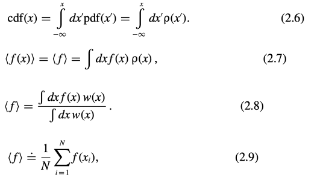

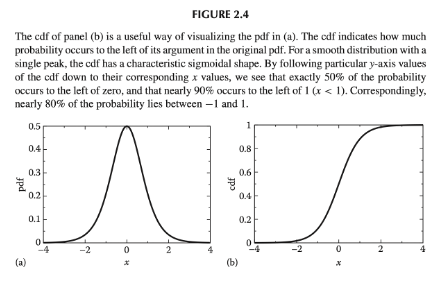

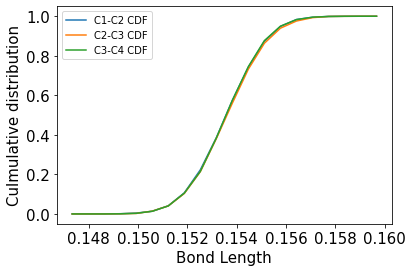

In [18]:
#ADD CODE FOR CDFs HERE#
# from solutions posted to github
C1C2_total = []
C2C3_total = []
C3C4_total = []

y = 0
for i in C1C2_density:
    y += i
    C1C2_total.append(y)
y = 0
for i in C2C3_density:
    y += i
    C2C3_total.append(y)
y = 0
for i in C3C4_density:
    y += i
    C3C4_total.append(y)

plt.plot(centers,C1C2_total, '-', label = 'C1-C2 CDF')
plt.plot(centers,C2C3_total, '-', label = 'C2-C3 CDF')
plt.plot(centers,C3C4_total, '-', label = 'C3-C4 CDF')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Culmulative distribution', size=15)
plt.yticks(size=15)
plt.show()

### homework problem #3: draw some different random frames from our trajectory (for example, 10, 100, and 1000), calculate the probability distribution functions for 5 of these random samples, and fit gaussians to these probability distribution functions
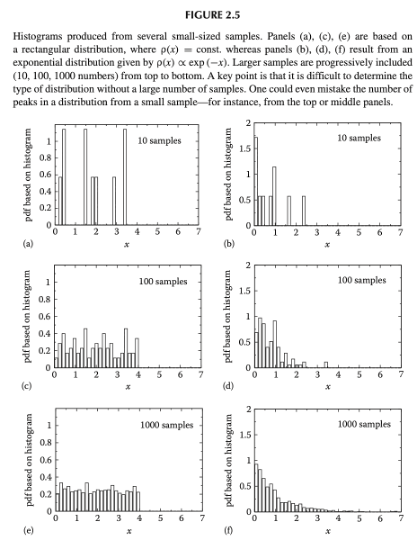

Frame number selected: 10
a: 0.20877876104936752 	x0: 0.153629542767438 	fit_sigma: -0.0011256650669832227
a: 0.1013977395412718 	x0: 0.15389254634959904 	fit_sigma: -0.0027278796765421013
a: 0.1943647442618749 	x0: 0.15467726024602996 	fit_sigma: 0.0013591623806370368


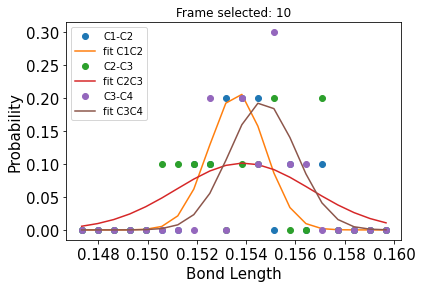

Frame number selected: 50
a: -0.004205540060731039 	x0: -2.2456333891277382 	fit_sigma: 0.2712597127126724
a: 0.1886137065108763 	x0: 0.15394666124379036 	fit_sigma: 0.001450707930342023
a: 0.9776135653801832 	x0: 1.359922591902376 	fit_sigma: 0.16073516462579218


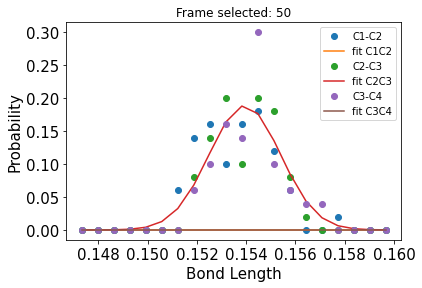

Frame number selected: 100
a: -2.4676596540606903 	x0: -7.269682681260132 	fit_sigma: -0.3664637586887154
a: 0.19876435527107109 	x0: 0.15410063878461266 	fit_sigma: 0.0013152636846731002
a: 0.1751109790688512 	x0: 0.15402605147674878 	fit_sigma: 0.0014894974058601686


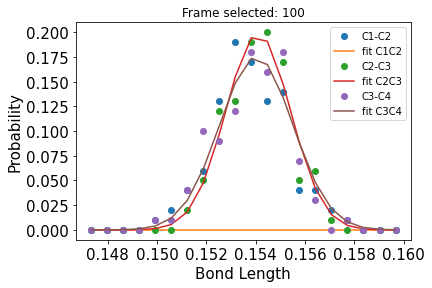

Frame number selected: 1000
a: 0.1780786168196165 	x0: 0.1538623451949468 	fit_sigma: -0.0014798259787342464
a: 0.18407194450850056 	x0: 0.15400571903591656 	fit_sigma: -0.0014300774382369178
a: 0.18327404923313673 	x0: 0.15383721648695045 	fit_sigma: -0.0014285353712012042


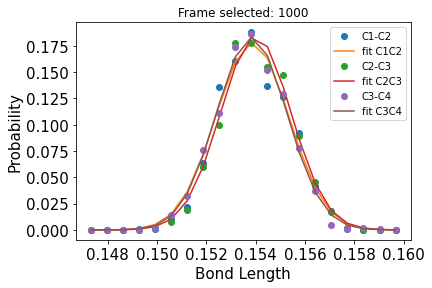

Frame number selected: 5000
a: 0.18571410104069644 	x0: 0.15395484773255005 	fit_sigma: -0.0014040626530208893
a: 0.18777094903884164 	x0: 0.15391701618725126 	fit_sigma: -0.0013817047070051555
a: 0.18742280597528374 	x0: 0.15387246554484071 	fit_sigma: 0.001387095870580893


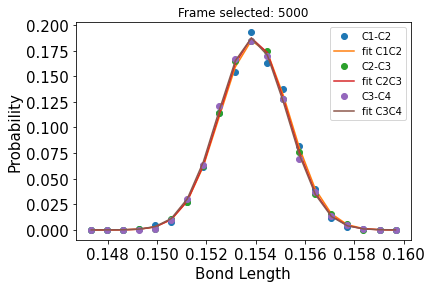

<Figure size 432x288 with 0 Axes>

In [19]:
#ADD CODE FOR Random Samples here#
#Draw 10,100,1000 random samples of a bond angle,

#This function might be helpful:
rands=np.random.randint(10000, size=(10))
rands

# from solutions posted to github
frame_length = [10,50,100,1000,5000]
for i in frame_length:
    rands=np.random.randint(10000, size=(i))
    print('Frame number selected: ' + str(i))
    C1C2_short = C1C2bondlength[rands]
    C2C3_short = C2C3bondlength[rands]
    C3C4_short = C3C4bondlength[rands]
    C1C2_short_density, centers = histogram_bincenters(C1C2_short, 0.147, 0.160, 20)
    C1C2_short_fit, C1C2_short_fit_params = fit_gauss(centers,C1C2_short_density)

    C2C3_short_density, centers = histogram_bincenters(C2C3_short, 0.147, 0.160, 20)
    C2C3_short_fit, C2C3_short_fit_params = fit_gauss(centers,C2C3_short_density)

    C3C4_short_density, centers = histogram_bincenters(C3C4_short, 0.147, 0.160, 20)
    C3C4_short_fit, C3C4_short_fit_params = fit_gauss(centers,C3C4_short_density)

    plt.plot(centers,C1C2_short_density, 'o', label = 'C1-C2')
    plt.plot(centers, C1C2_short_fit, '-', label='fit C1C2')
    plt.plot(centers,C2C3_short_density, 'o', label = 'C2-C3')
    plt.plot(centers, C2C3_short_fit, '-', label='fit C2C3')
    plt.plot(centers,C3C4_short_density, 'o', label = 'C3-C4')
    plt.plot(centers, C3C4_short_fit, '-', label='fit C3C4')

    plt.legend()
    plt.title('Frame selected: ' + str(i))
    plt.xlabel('Bond Length', size=15)
    plt.xticks(size=15)
    plt.ylabel('Probability', size=15)
    plt.yticks(size=15)
    plt.show()
    plt.clf()

### class activity: compute the two C-C-C bond angles and C-C-C-C dihedral angle

plot their time courses and histograms; find a good way to visualize the C-C-C-C dihedral angle 

(10000, 2)


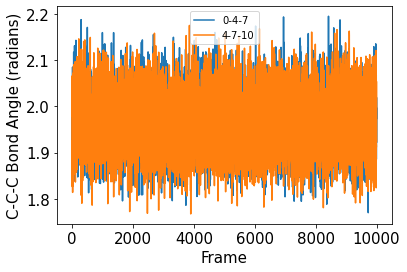

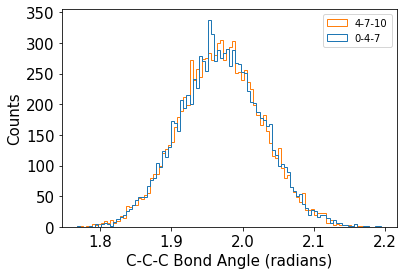

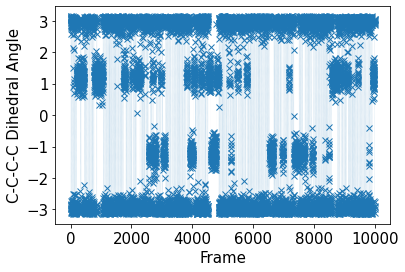

In [23]:
#compute some bond angles 
# partially from solutions posted to github
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
#ang=np.degrees(angle_rad)
print(np.shape(ang))
plt.plot(ang,label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('Frame', size=15)
plt.xticks(size=15)
plt.ylabel('C-C-C Bond Angle (radians)', size=15)
plt.yticks(size=15)
plt.show()

plt.show()
plt.clf()
plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()
plt.clf()

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

#plt.plot(CCCC_torsion)
plt.plot(CCCC_torsion,marker='x',linewidth=.01)
#plt.xlim(0,2000)
plt.xlabel('Frame', size=15)
plt.xticks(size=15)
plt.ylabel('C-C-C-C Dihedral Angle', size=15)
plt.yticks(size=15)
plt.show()

### homework challenge question:  estimate the lifetime of the higher energy C-C-C-C dihedral states

Gauche Transitions: 49
Average Residence Time (ps): 15318.367346938774


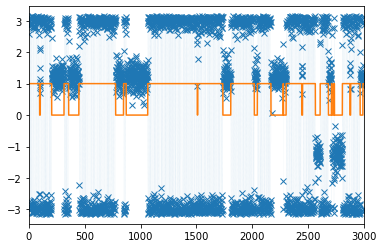

In [25]:
# from solutions posted to github
time_series=CCCC_torsion[:,0]
state_assign=np.zeros(len(time_series))
frame_set=np.where((CCCC_torsion[:,0]<-2) | (CCCC_torsion[:,0]>2))
state_assign[frame_set]=1
plt.plot(time_series,marker='x',linewidth=.01)
plt.plot(state_assign)
plt.xlim(0,3000)

gauche=0
n=0
res_time=[]

for i in range(1,len(state_assign)):
    if state_assign[i]==1:
     if gauche==0:
      gauche=1
     n+=1
    if state_assign[i]==0:
     gauche=0   
     if state_assign[i-1]!=0:
      res_time.append(n)
      n=0
#Traj=1000000 ps / 10000 frames
#100ps/frame
print("Gauche Transitions:",len(res_time))
print("Average Residence Time (ps):",np.average(res_time)*100)

### class activity: are the bond angles and dihedral angle correlated?

R2: -0.010936790535337677
Line Parameters: [-2.42552035e-04  1.96979911e+00]


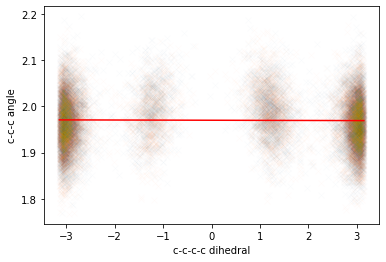

In [28]:
plt.scatter(dihe,ang1,marker='x',linewidth=0.01)
plt.scatter(dihe,ang2,marker='x',linewidth=0.01)

r2=np.corrcoef(dihe,ang1)[0,1]
print("R2:",r2)

line_fit=np.polyfit(dihe,ang1,1)
x = np.linspace(min(dihe), max(dihe),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.xlabel('c-c-c-c dihedral')
plt.ylabel('c-c-c angle')
plt.show()
#plt.scatter(ang1[1:-1:10],ang2[1:-1:10])
#r=np.corrcoef(ang1, ang2)
#print("Angle Correlation r^2:",r[0,1])

### homework problem 3: express the relationsip between these two quantities using histograms and conditional probabilities

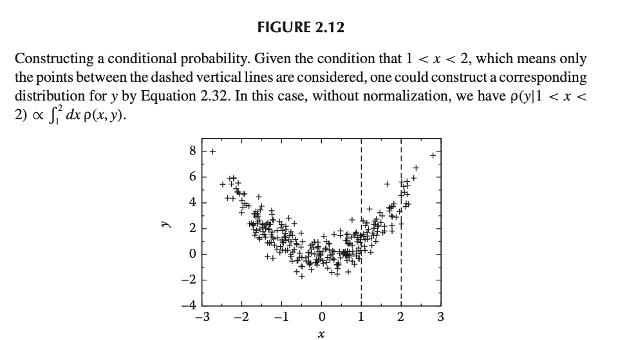

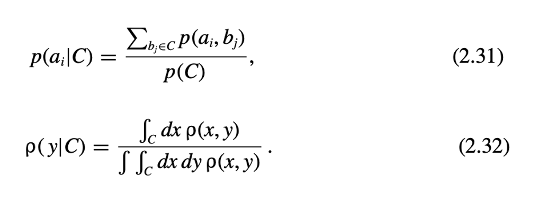

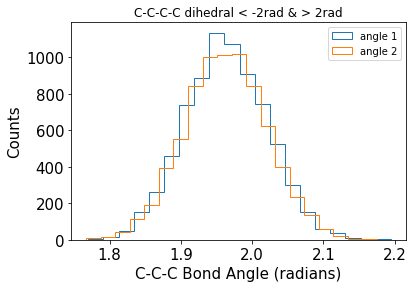

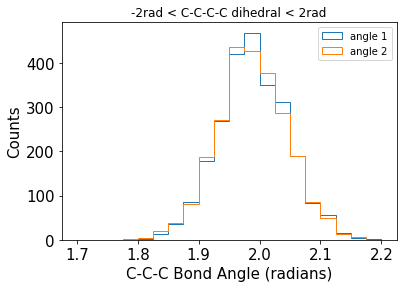

In [30]:
#Homework problem 3
# from solutions posted to github
#Slice the dihedral angle to get all frames in a given interval

frame_set=np.where((CCCC_torsion[:,0]<-2) | (CCCC_torsion[:,0]>2))

plt.hist(ang1[frame_set],histtype='step',label='angle 1',bins=20)
plt.hist(ang2[frame_set],histtype='step',label='angle 2',bins=20)
plt.legend()
plt.title('C-C-C-C dihedral < -2rad & > 2rad')
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)

plt.show()
plt.clf()

frame_set=np.where((CCCC_torsion[:,0]>-2) & (CCCC_torsion[:,0]<2))
plt.title('-2rad < C-C-C-C dihedral < 2rad')

plt.hist(ang1[frame_set],histtype='step',label='angle 1',bins=20,range=[1.7,2.2])
plt.hist(ang2[frame_set],histtype='step',label='angle 2',bins=20,range=[1.7,2.2])
plt.legend()
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

### class activity: calculate the autocorrelation times of C-C bonds, C-C-C angles, and C-C-C-C dihedrals

[0.00000000e+00 2.00020002e+00 4.00040004e+00 ... 1.99959996e+04
 1.99979998e+04 2.00000000e+04]


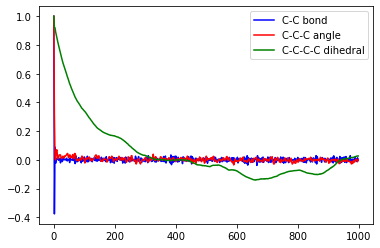

<Figure size 432x288 with 0 Axes>

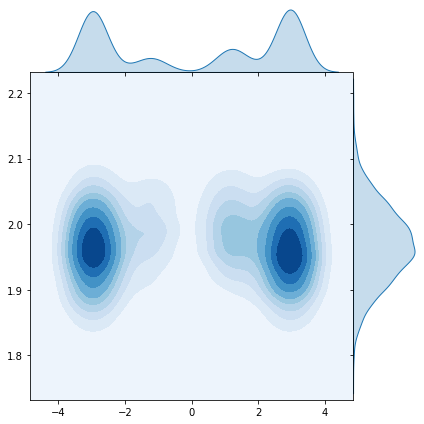

<Figure size 432x288 with 0 Axes>

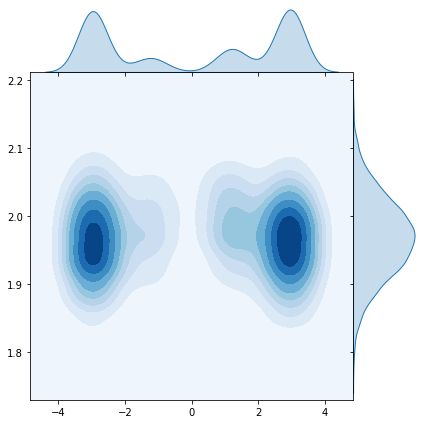

In [33]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(dihe),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()
plt.show()
plt.clf()

# from solutions posted to github
sb.jointplot(x=CCCC_torsion[:,0],y=ang1,kind = 'kde', space=0, fill=True, thresh=0, cmap='Blues')
plt.show()
plt.clf()
sb.jointplot(x=CCCC_torsion[:,0],y=ang2,kind = 'kde', space=0, fill=True, thresh=0, cmap='Blues')
plt.show()

### class activity: dig into a force field XML file and make plots of the force field torsion terms

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

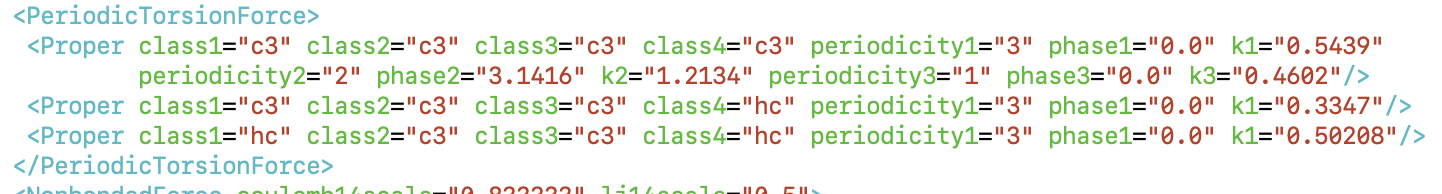

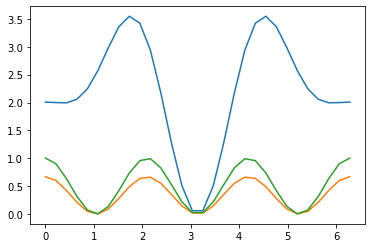

In [34]:
#Plot The Torsion Force Field Terms
# from solutions posted to github
# make a linspace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

# function takes paramaters from the xml and writes the force field term
def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)

plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)
plt.show()

In [35]:
# review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [36]:
#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#HCCC torsions, eg 13 0 4 7
#HCCH torsions, eg 5  4 7 8 etc etc (build up big array)

# from solutions posted to github
#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

### homework problem #5: many of these correlations will be highly-correlated&mdash;select some torsions that are correlated and some that are not and make scatter plots of their relationships

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  Why isn't it always the same?

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

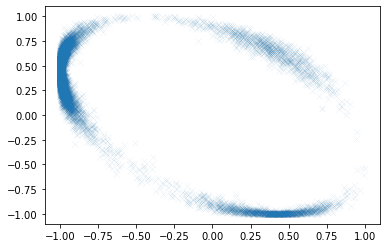

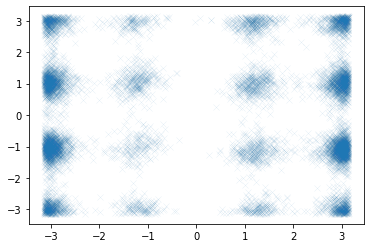

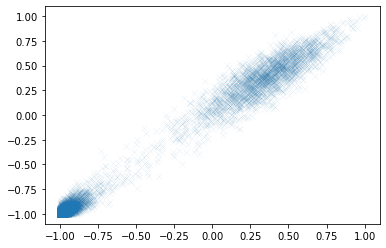

In [38]:
####Homework Problem 5 - Correlations in torsion paramaters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Consider CCCC vs. [8,7,4,5]
# from solutions posted to github
plt.scatter(np.cos(HCCH_torsions[:,0]),np.cos(HCCH_torsions[:,1]),marker='x',linewidth=0.04)
plt.show()
plt.clf()

#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9]
plt.scatter(CCCC_torsion,HCCH_torsions[:,14],marker='x',linewidth=0.04)
plt.show()
plt.clf()

plt.scatter(np.cos(CCCC_torsion),np.cos(HCCH_torsions[:,0]),marker='x',linewidth=0.04)
plt.show()

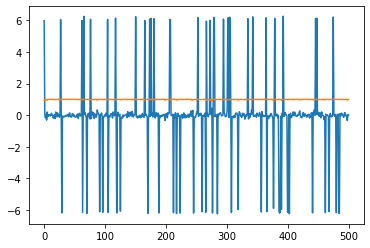

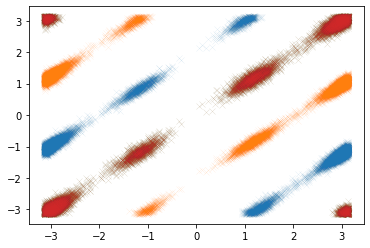

In [40]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT
#plt.scatter(CCCC_torsion,HCCH_torsions[:,1],marker='x',linewidth=0.04)
#diff=CCCC_torsion[:,0]-HCCH_torsions[:,3]
# from solutions posted to github
diff=CCCC_torsion[:,0]-HCCH_torsions[:,3]
plt.plot(diff[::20])
plt.plot(np.cos(diff[::20]))
plt.show()
plt.clf()

plt.scatter(HCCH_torsions[:,0],HCCH_torsions[:,1],marker='x',linewidth=0.04)
plt.scatter(HCCH_torsions[:,0],HCCH_torsions[:,2],marker='x',linewidth=0.04)
plt.scatter(HCCH_torsions[:,0],HCCH_torsions[:,3],marker='x',linewidth=0.04)
plt.scatter(HCCH_torsions[:,0],HCCH_torsions[:,3],marker='x',linewidth=0.04)
plt.show()

In [41]:
#COMPUTE THE TOTAL TORSION FORCE FIELD ENERGY PER FRAME
# from solutions posted to github
#plt.scatter(CCCH_torsions[:,0],CCCH_E[:,0])
CCCC_E=CCCC_torsionE(CCCC_torsion[:,0])
HCCH_E=HCCH_torsionE(HCCH_torsions)
CCCH_E=CCCH_torsionE(CCCH_torsions)
HCCH_totalE=np.sum(HCCH_E,axis=1)
CCCH_totalE=np.sum(CCCH_E,axis=1)
Total_TorsionE=CCCC_E+HCCH_totalE+CCCH_totalE

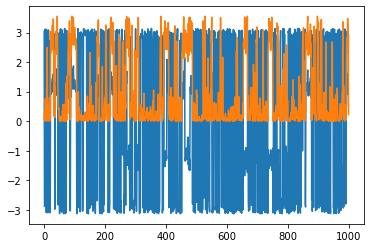

In [42]:
#Compare the time course of CCCC torsion with its energy 
#Interpret what you are seeing in terms of conformations and energies
# from solutions posted to github
CCCC_E=CCCC_torsionE(CCCC_torsion[:,0])
plt.plot(CCCC_torsion[:,0][::10])
plt.plot(CCCC_E[::10])
plt.show()

plot the total torsion energy as a function of the C-C-C-C dihedral angle - compare your plot energetic torsion barriers from cramer. How can you explain the difference?

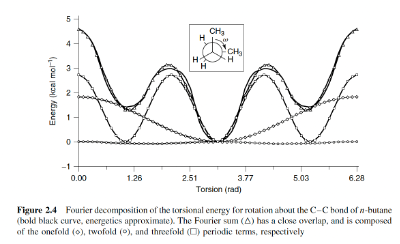

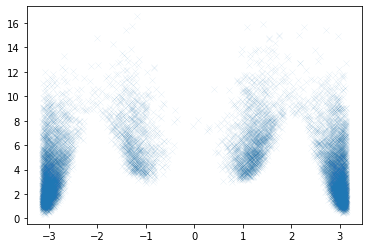

In [43]:
# from solution posted to github
plt.scatter(CCCC_torsion[:,0],Total_TorsionE,marker='x',linewidth=.04)
plt.show()

### homework problem #6: modify the C-C-C-C torsion potential to change the dihedral distribution

try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at it by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

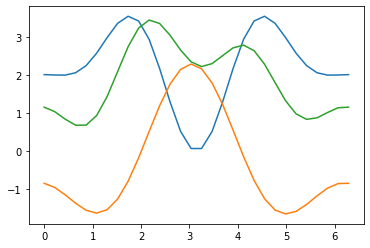

In [44]:
###SOLUTION#####
# from solutions posted to github
def CCCC_cor(angle):
 e1=calc_torsion_energy(angle,-2.16,1,-0.4)
 e2=calc_torsion_energy(angle,0.8,1,-1)
 e3=calc_torsion_energy(angle,1.04,2,-0.2)
 return e1+e2+e3

CCCC_corE=CCCC_cor(rad_ang)
CCCC_e=CCCC_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCC_corE)
plt.plot(rad_ang,CCCC_corE+CCCC_e)


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

### homework problem #7: attempt to run a new MD simulation with your modified torsion potential

Once you have made a torsion correction, make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [45]:
# from solutions posted to github
#ONCE YOU HAVE FOUND SOME TORSION CORRECTIONS RUN A NEW SIMULATION 
#Make a new force field file 'butane.gaff2.cor1.xml'

print(initial_pdb)
print(force_field)

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*openmm.unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

project1_data/butane.pdb
project1_data/butane.gaff2.xml
Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295784483017471 kJ/mol
Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,23.819836923999784,236.8136526822083
200,34.12207749817702,195.63316231123508
300,42.21239515185732,193.83314650204963
400,46.55687634813891,339.70225046247003
500,47.36818364702336,290.592906552884
600,49.88070963024674,282.6641028524742
700,63.75025782729823,366.28848686282265
800,28.115216975030407,383.65978587283973
900,36.395369242860085,255.75755793368893
1000,40.93013368498714,274.90392084820394
1100,36.46836515642021,378.99102149141765
1200,54.99642635149695,301.70155796872024
1300,37.87860227095487,491.9500527706511
1400,33.70829469598642,391.6506805631648
1500,24.647547290515146,231.0692752142453
1600,42.82928855061999,199.39951678412598
1700,37.25150437846281,145.30274169705933
1800,59.630967055146485,303

In [47]:
# from solutions posted to github
import time as time
print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.cor1.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(1000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,50.0002553350395,137.62826519903624,0
500000,999.9999999901769,30.448850022140885,271.34065102088016,2.81e+03
750000,1499.9999999783536,53.702862506828446,289.6638208977163,2.76e+03
1000000,1999.9999999665301,43.54101521571504,322.6921646846388,2.77e+03
Done!
Time required for simulation: 61.22611141204834 seconds


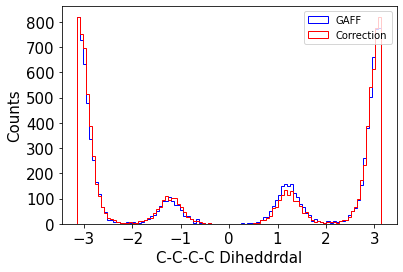

NGLWidget(max_frame=9999)

In [48]:
# from solutions posted to github
traj2 = md.load(workDir+'butane_sim.cor1.dcd', top=initial_pdb)
traj2
#traj.superpose(ref)
CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
CCCC_torsion2=md.compute_dihedrals(traj2, [CCCC_index])
plt.hist(CCCC_torsion,bins=100,histtype='step',color='b',label='GAFF')
plt.hist(CCCC_torsion2,bins=100,histtype='step',color='r',label='Correction')

plt.legend(loc='upper right')
plt.xlabel('C-C-C-C Diheddrdal', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

t = ngl.MDTrajTrajectory(traj2)
w = ngl.NGLWidget(t)
w

Gauche Transitions: 54 Average Residence Time (ps): 13831.481481481482


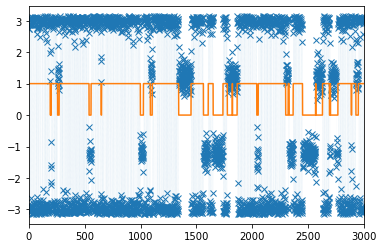

In [49]:
# from solutions posted to github
time_series=CCCC_torsion2[:,0]
state_assign=np.zeros(len(time_series))
frame_set=np.where((CCCC_torsion2[:,0]<-2) | (CCCC_torsion2[:,0]>2))
state_assign[frame_set]=1
plt.plot(time_series,marker='x',linewidth=.01)
plt.plot(state_assign)
plt.xlim(0,3000)

gauche=0
n=0
res_time=[]

for i in range(1,len(state_assign)):
    if state_assign[i]==1:
     if gauche==0:
      gauche=1
     n+=1
    if state_assign[i]==0:
     gauche=0   
     if state_assign[i-1]!=0:
      res_time.append(n)
      n=0
#Traj=1000000 ps / 10000 frames
#100ps/frame
print("Gauche Transitions:",len(res_time),"Average Residence Time (ps):",np.average(res_time)*100)

### homework problem #8:  calculate LJ and Coulomb forcefield potentials for 3 types of atom pairs

### challenge problem:  attempt to calculate all LJ interactions for a frame and all frames.  What does lj14scale mean?

### challenge problem #2:  attempt to calculate all Coulomb interactions for a frame and all frames

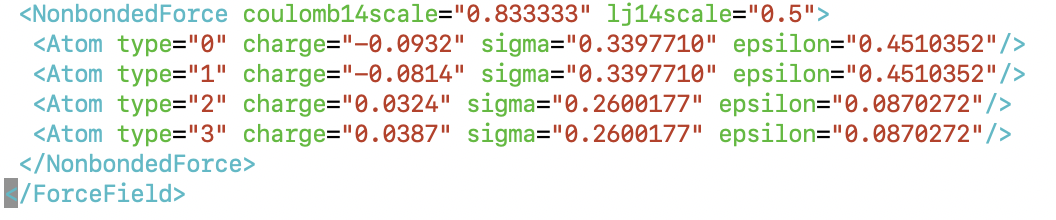

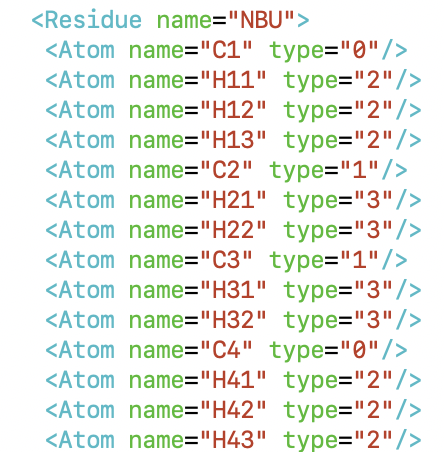

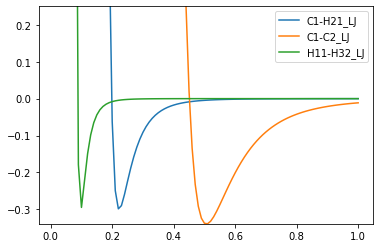

In [50]:
#Calculate LJ and Couloumb Potentials Here
# from solutions posted to github

sig1 = 0.3397710
ep1 = 0.4510352
sig2 = 0.2600177
ep2 = 0.0870272
c1 = -0.0932
c2 = -0.0814
c3 = 0.0324
c4 = 0.0387 
# Type 1: C1-H21 (0-3), type2 = C1-C2 (0-1), type3 = H11-H32 (2-3)
r = np.linspace(0.01,1.0,100)
def LJ(sig,ep,r):
    A = 4*sig*(ep**12)
    B = 4*sig*(ep**6)
    return A/(r**12)-B/(r**6)

def combine_sig(sig1,sig2):
    return 0.5*sig1 + 0.5*sig2

def combine_ep(ep1,ep2):
    return (ep1*ep2)**0.5

C1H21_LJ = LJ(combine_sig(sig1,sig2),combine_ep(ep1,ep2),r)
C1C2_LJ = LJ(combine_sig(sig1,sig1),combine_ep(ep1,ep1),r)
H11H32_LJ = LJ(combine_sig(sig2,sig1),combine_ep(ep2,ep2),r)

plt.plot(r,C1H21_LJ, label = 'C1-H21_LJ')
plt.plot(r,C1C2_LJ, label = 'C1-C2_LJ')
plt.plot(r,H11H32_LJ, label = 'H11-H32_LJ')
plt.ylim(min(C1C2_LJ),.25)
plt.legend()
plt.show()

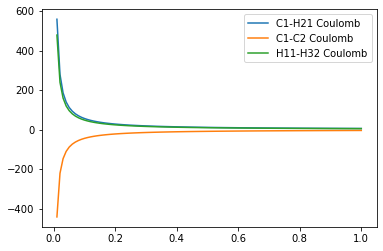

In [52]:
# Coulumbic potential
# Atom paird: 0-1, 1-2, 2-3
# from solutions posted to github

def coulumb(q1,q2,r,ep):
    return (332*q1*q2)/(ep*r)

co1 = coulumb(c1,c2,r,combine_ep(ep1,ep1))
co2 = coulumb(c2,c3,r,combine_ep(ep1,ep2))
co3 = coulumb(c3,c4,r,combine_ep(ep2,ep2))

plt.plot(r,co1, label = 'C1-H21 Coulomb')
plt.plot(r,co2, label = 'C1-C2 Coulomb')
plt.plot(r,co3, label = 'H11-H32 Coulomb')
plt.legend()
plt.show()